<a href="https://colab.research.google.com/github/jeffyjohny7/ict/blob/main/jeffy_assignment_on_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Necessary Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,\
StratifiedKFold,cross_val_score

from sklearn.preprocessing import Normalizer, LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import RocCurveDisplay

1. Load And Explore The Data

In [9]:
# Load the dataset

titanic = pd.read_csv('titanic_dataset.xls.csv')
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [10]:
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
titanic.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [13]:
# Rearrange the column orders to ease the analysis

titanic = titanic[['PassengerId', 'Name',
    'Sex', 'Age', 'SibSp','Parch', 'Pclass',
    'Ticket', 'Cabin', 'Fare',
    'Embarked', 'Survived']]

2. Preprocessing

It is better to drop columns such as PassengerId and Ticket

In [14]:

titanic = titanic.drop(['PassengerId','Ticket'],axis=1)

Extract Data From 'Cabin'

The Cabin column contains details of Deck and Room. There are some rows which have more than one Cabin, but comparatively it is less, so it is okay to ignore it for now.

In [15]:
# Get a copy of the cabin to perform analysis
cabin = titanic[['Cabin']].copy()

# Ge the data on 'Deck'
cabin["Cabin_Data"] = cabin["Cabin"].isnull().apply(lambda x: not x)
cabin["Deck"] = cabin["Cabin"].str.slice(0,1)

# Ge the data on 'Room'
cabin["Room"] = cabin["Cabin"].str.slice(1,5).str.extract(
    "([0-9]+)", expand=False).astype("float")

# Fill the 'NA' values
cabin['Deck'] = cabin['Deck'].fillna('N')
cabin["Room"] = cabin["Room"].fillna(cabin["Room"].mean())

# Drop unnecessary columns
cabin.drop(['Cabin','Cabin_Data'],axis=1,inplace=True)

# Embedd the extracted data into the original dataset
titanic[['Deck','Room']] = cabin[['Deck','Room']]

del cabin

Extract Data From the 'Family' column

In [16]:
titanic['Family_Onboard'] = (titanic
 ['SibSp'] + titanic['Parch']+1).astype(int)
titanic = titanic.drop(['SibSp','Parch'],axis=1)


Extract Data From the 'Name' column

In [17]:
titanic['Title'] = titanic.Name.str.extract(
    ' ([A-Za-z]+)\.',expand=False)

titanic['Title'] = titanic['Title'].replace(
    ['Ms','Mlle'],'Miss')
titanic['Title'] = titanic['Title'].replace(
    ['Mme'],'Mrs')

titanic['Title'] = titanic['Title'].replace(
    ['Don', 'Rev', 'Dr', 'Major', 'Lady',
       'Sir', 'Col', 'Capt', 'Countess',
      'Jonkheer'],'Others')

titanic = titanic.drop('Name',axis=1)

Rearrange the Columns

In [18]:
titanic = titanic[['Title', 'Sex', 'Age',
    'Family_Onboard','Pclass','Deck',
    'Room','Fare', 'Embarked', 'Survived']]

titanic.head(1)


,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,Mr,male,22.0,2,3,N,50.49,7.25,S,0


Fill Zeroes and Null Values

In [19]:
missing_values = titanic.isnull().sum()
missing_values[missing_values>0]/len(titanic)*100

Age         19.865320
Embarked     0.224467
dtype: float64

<Axes: >

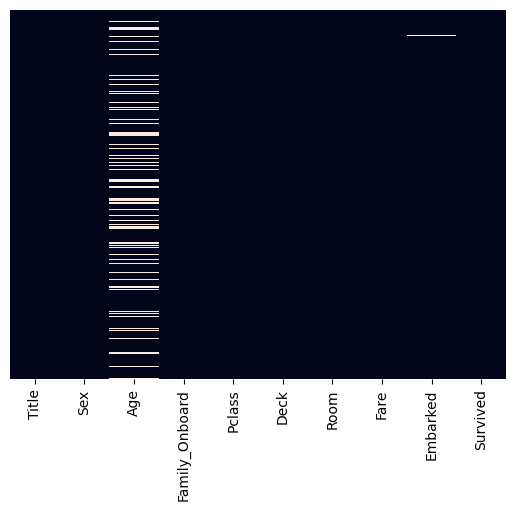

In [20]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False)

It would be convinient to fill Age column with median value (from the data median is 28.00)

In [21]:
impute = float(titanic['Age'].median())
titanic['Age'].fillna(impute, inplace= True)

Since, only three values embedded in the Embarked column, most suitable would be most frequent one, which can code with mode() function

In [22]:
impute = titanic['Embarked'].mode()[0]
titanic['Embarked'].fillna(impute, inplace= True)

Handling Outliers

Text(0.5, 1.0, 'Before Removing Outliers')

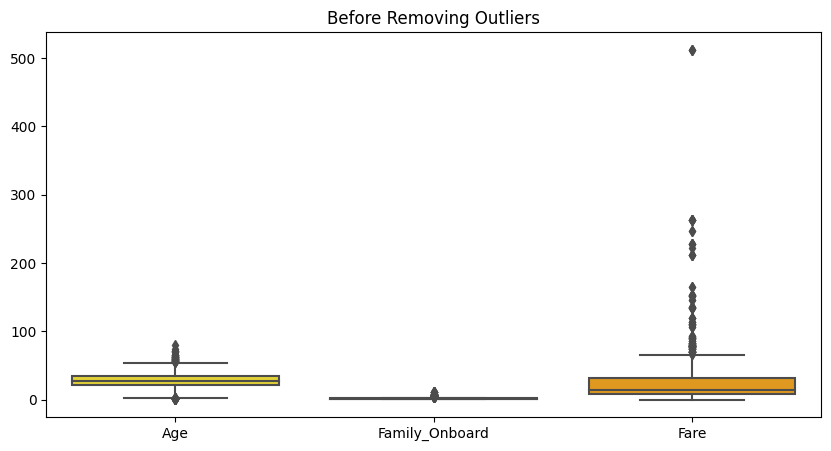

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(titanic[['Age',
      'Family_Onboard','Fare']]
        ,palette='Wistia')
plt.title("Before Removing Outliers")

In [25]:
# create function to find outliers

def outlier(col):
    c = 1.5

    IQR = np.quantile(titanic[col], 0.75) - np.quantile(titanic[col], 0.25)

    Max = np.quantile(titanic[col], 0.75) + c * IQR
    Min = np.quantile(titanic[col], 0.25) - c * IQR

    outlier.Max = Max
    outlier.Min = Min

    df = titanic[(titanic[col] > Max) | (titanic[col] < Min)]

    return df


In [27]:
# Imputation and Capping to reduce outliers

# Define the outlier function
def outlier(col):
    c = 1.5

    IQR = np.quantile(titanic[col], 0.75) - np.quantile(titanic[col], 0.25)

    Max = np.quantile(titanic[col], 0.75) + c * IQR
    Min = np.quantile(titanic[col], 0.25) - c * IQR

    outlier.Max = Max
    outlier.Min = Min

    df = titanic[(titanic[col] > Max) | (titanic[col] < Min)]

    return df

# Columns to perform imputation and capping
columns = ['Age', 'Family_Onboard', 'Fare']

# Imputation - Replace outliers with NaN
for key in columns:
    out = outlier(key)
    for i in out.index:
        titanic.loc[i, key] = np.nan

# Impute NaN values with the mean
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)
titanic['Family_Onboard'].fillna(titanic['Family_Onboard'].mean(), inplace=True)
titanic['Fare'].fillna(titanic['Fare'].mean(), inplace=True)

# Capping - Replace outliers with the upper bound
for key in columns:
    out = outlier(key)
    titanic[key] = np.where(titanic[key] > outlier.Max, outlier.Max, titanic[key])

# Now the outliers are capped, and NaN values are imputed with the mean


Text(0.5, 1.0, 'After Removing Outliers')

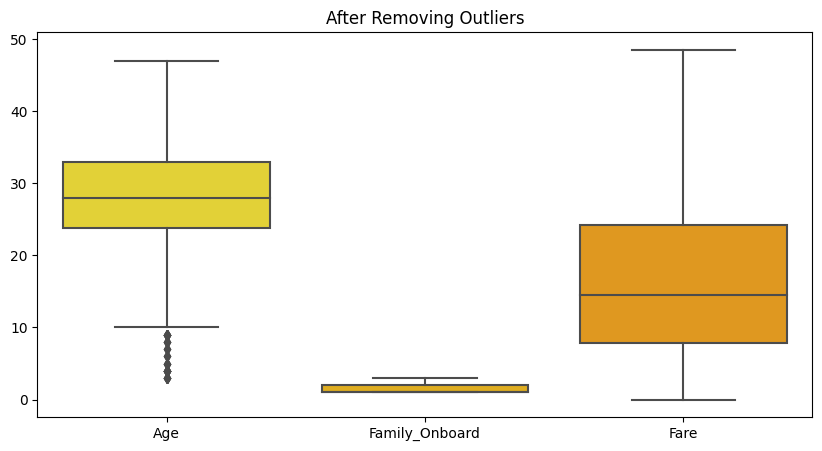

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(titanic[['Age','Family_Onboard','Fare']],palette='Wistia')
plt.title("After Removing Outliers")

Encoding Categorical Values

In [29]:
sex_en = {'male':0,'female':1}
titanic['Sex'] = titanic['Sex'].replace(sex_en)

title_en = {'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Others':4}
titanic['Title'] = titanic['Title'].replace(title_en)

emb_en = {'S':0,'C':1,'Q':2}
titanic['Embarked'] = titanic['Embarked'].replace(emb_en)

dk_en = LabelEncoder().fit_transform(titanic['Deck'])
titanic['Deck'] = pd.DataFrame(dk_en,columns=['Deck'])

titanic.head(3)


,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,0,0,22.0,2.0,3,7,50.49,7.250000,0,0
1,1,1,38.0,2.0,1,2,85.00,17.822091,1,1
2,2,1,26.0,1.0,3,7,50.49,7.925000,0,1


Scaling On Necessary Columns

In [30]:
std = Normalizer().fit_transform(titanic[['Age','Fare','Room']])

scaled = pd.DataFrame(std,columns=['Age','Fare','Room'])

titanic['Age'] = scaled['Age']
titanic['Fare'] = scaled['Fare']
titanic['Room'] = scaled['Room']

titanic.head(3)

,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,0,0,0.396040,2.0,3,7,0.908911,0.130513,0,0
1,1,1,0.400853,2.0,1,2,0.896645,0.188001,1,1
2,2,1,0.453424,1.0,3,7,0.880514,0.138207,0,1


3. Machine Learning

In [31]:
x = titanic.iloc[:,0:-1]
y = titanic.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(
    x,y,random_state=91, test_size=0.1)


1. K-Nearest Neighbors Classifiers

In [32]:
knn_classifier = KNeighborsClassifier(n_neighbors=2).fit(x_train,y_train)
knn_score = knn_classifier.score(x_test,y_test)
print(f'KNN Accuracy Score: {knn_score*100:.2f}%')

k_fold = KFold(n_splits = 3,random_state = 8, shuffle=True)
kfold_result = cross_val_score(knn_classifier,x,y,cv=k_fold)
print(f'KNN Accuracy Score with KFold CV: {kfold_result.mean()*100:.2f}%')

sk_fold = StratifiedKFold(n_splits = 4 ,random_state = 0, shuffle=True)
skfold_result = cross_val_score(knn_classifier,x,y,cv=sk_fold)
print(f'KNN Accuracy Score with Stratified CV: {skfold_result.mean()*100:.2f}%')

KNN Accuracy Score: 85.56%
KNN Accuracy Score with KFold CV: 80.36%
KNN Accuracy Score with Stratified CV: 80.47%


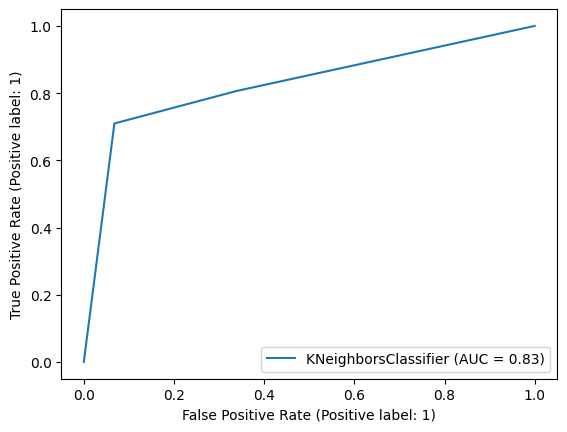

In [33]:
svc_disp = RocCurveDisplay.from_estimator(knn_classifier, x_test, y_test)


2. Support Vector Classifiers

In [34]:
svm_classifier = SVC(C=34, random_state=0,
          probability=True).fit(x_train,y_train)
svm_score = svm_classifier.score(x_test,y_test)
print(f'SVC Accuracy Score:{svm_score*100:.2f}%')

svc_fold = KFold(n_splits = 9,random_state = 18,
                 shuffle=True)
svc_fold_result = cross_val_score(svm_classifier,
                                  x,y,cv=svc_fold)
print(f'SVC Accuracy Score with KFold CV:{svc_fold_result.mean()*100:.2f}%')

svc_sfold = StratifiedKFold(n_splits = 22,random_state = 30, shuffle=True)
svc_sfold_result = cross_val_score(svm_classifier,x,y,cv=svc_sfold)
print(f'SVC Accuracy Score with Stratified CV:{svc_sfold_result.mean()*100:.2f}%')

SVC Accuracy Score:86.67%
SVC Accuracy Score with KFold CV:83.61%
SVC Accuracy Score with Stratified CV:83.29%


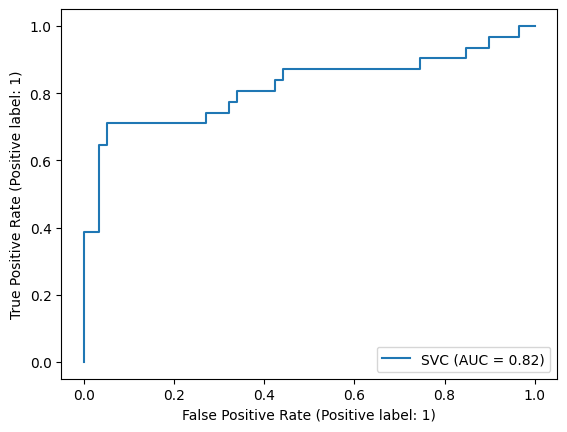

In [35]:
svc_disp = RocCurveDisplay.from_estimator(svm_classifier, x_test, y_test)

4. Evaluation

The result shows that KNN algorithm performed better than SVC. But, on cross validation it did not have improvement on both models, also it worsned the output of KNN, and on SVC it may reduced the accuracy, but still better than what it done on KNN.

Summarazing that KNN performed well without cross-validation, and SVC performed while cross validation is active.